In [190]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

from sklearn.metrics import mean_squared_error
from math import sqrt

import acquire

In [191]:
saas = pd.read_csv('saas.csv')
saas

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...,...
790453,2017-12-31,1029395,5790453,0.0,0.0
790454,2017-12-31,1029396,5790454,0.0,0.0
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0


In [192]:
saas.isnull().sum()

Month_Invoiced       0
Customer_Id          0
Invoice_Id           0
Subscription_Type    0
Amount               0
dtype: int64

In [193]:
saas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [194]:
saas['Month_Invoiced'] = pd.to_datetime(saas['Month_Invoiced'])

In [195]:
saas = saas.set_index('Month_Invoiced')

In [196]:
saas = saas.drop(columns = ['Customer_Id', 'Invoice_Id', 'Subscription_Type'])

In [197]:
saas.isnull().sum()

Amount    0
dtype: int64

In [198]:
idx = pd.date_range('2014-01-31', '2017-12-31')

In [201]:
saas['Amount'] = saas['Amount'].resample('d').mean()

In [203]:
saas.isnull().sum()

Amount    0
dtype: int64

In [204]:
train_size = int(round(saas.shape[0] * 0.7))
validate_size = int(round(saas.shape[0] * 0.2))
test_size = int(round(saas.shape[0] * 0.1))

In [205]:
saas

,Amount
Month_Invoiced,
2014-01-31,1.792500
2014-01-31,1.792500
2014-01-31,1.792500
2014-01-31,1.792500
2014-01-31,1.792500
...,...
2017-12-31,3.866969
2017-12-31,3.866969
2017-12-31,3.866969


In [206]:
train_size, validate_size, test_size

(553321, 158092, 79046)

In [207]:
validate_end_index = train_size + validate_size

In [208]:
train = saas[:train_size]
validate = saas[train_size:validate_end_index]
test = saas[validate_end_index:]

In [209]:
def time_series_subset(df):
    '''
    function that does what I did above
    '''
    train_size = int(round(df.shape[0] * 0.5))
    validate_size = int(round(df.shape[0] * 0.3))
    test_size = int(round(df.shape[0] * 0.2))
    
    print(train_size, validate_size, test_size)
    print(len(df) == train_size + validate_size + test_size)
    
    validate_end_index = train_size + validate_size
    
    train = df[:train_size]
    validate = df[train_size:validate_end_index]
    test = df[validate_end_index:]
    
    return train, validate, test

### Simple Average Forecast

In [210]:
train

,Amount
Month_Invoiced,
2014-01-31,1.792500
2014-01-31,1.792500
2014-01-31,1.792500
2014-01-31,1.792500
2014-01-31,1.792500
...,...
2016-08-31,3.447737
2016-08-31,3.447737
2016-08-31,3.447737


In [211]:
avg_sales = round(train['Amount'].mean(), 2)
avg_sales

2.7

In [212]:
yhat_df = pd.DataFrame({'Amount': [avg_sales]}, index = validate.index)

In [213]:
yhat_df

,Amount
Month_Invoiced,
2016-08-31,2.7
2016-08-31,2.7
2016-08-31,2.7
2016-08-31,2.7
2016-08-31,2.7
...,...
2017-07-31,2.7
2017-07-31,2.7
2017-07-31,2.7


<AxesSubplot:xlabel='Month_Invoiced'>

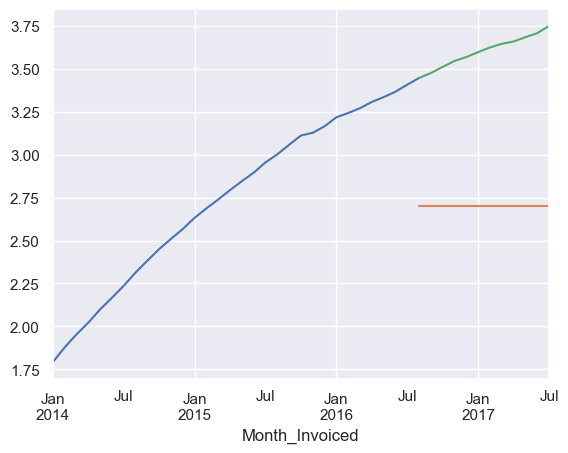

In [214]:
train.resample('M')['Amount'].mean().plot()
yhat_df.resample('M')['Amount'].mean().plot()
validate.resample('M')['Amount'].mean().plot()

In [215]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [216]:
evaluate('Amount')

1.0

In [217]:
evaluates = pd.DataFrame({'model_type' : ['Simple_Average'], 'RMSE' : [evaluate('Amount')]})

In [218]:
evaluates

,model_type,RMSE
0,Simple_Average,1.0


# Moving Average

In [219]:
period=30
rolling = round(train['Amount'].rolling(period).mean()[-1], 3)

In [220]:
yhat_df = yhat_df.assign(moving = rolling)

<AxesSubplot:xlabel='Month_Invoiced'>

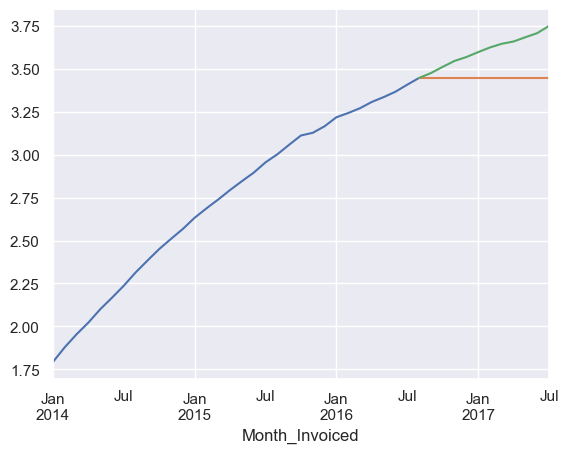

In [221]:
train.resample('M')['Amount'].mean().plot()
yhat_df.resample('M')['moving'].mean().plot()
validate.resample('M')['Amount'].mean().plot()

In [222]:
yhat_df

,Amount,moving
Month_Invoiced,,
2016-08-31,2.7,3.448
2016-08-31,2.7,3.448
2016-08-31,2.7,3.448
2016-08-31,2.7,3.448
2016-08-31,2.7,3.448
...,...,...
2017-07-31,2.7,3.448
2017-07-31,2.7,3.448
2017-07-31,2.7,3.448


In [223]:
rmse = round(sqrt(mean_squared_error(validate['Amount'], yhat_df['moving'])), 3)
rmse

0.174

In [224]:
rollings = pd.DataFrame({'model_type': ['Rolling_average'], 'RMSE': [rmse]})

In [225]:
rollings

,model_type,RMSE
0,Rolling_average,0.174


In [226]:
pd.concat([evaluates, rollings])

,model_type,RMSE
0,Simple_Average,1.000
0,Rolling_average,0.174


# Holt's model

In [227]:
train['Amount'] = train.Amount.resample('M').mean()

In [228]:
train

,Amount
Month_Invoiced,
2014-01-31,1.792500
2014-01-31,1.792500
2014-01-31,1.792500
2014-01-31,1.792500
2014-01-31,1.792500
...,...
2016-08-31,3.447737
2016-08-31,3.447737
2016-08-31,3.447737


In [251]:
train['Amount']

Month_Invoiced
2014-01-31    1.792500
2014-01-31    1.792500
2014-01-31    1.792500
2014-01-31    1.792500
2014-01-31    1.792500
                ...   
2016-08-31    3.447737
2016-08-31    3.447737
2016-08-31    3.447737
2016-08-31    3.447737
2016-08-31    3.447737
Name: Amount, Length: 553321, dtype: float64

In [229]:
col = 'Amount'
model = Holt(train[col], exponential=False, damped=True)


In [230]:
model = model.fit(optimized=True)

In [237]:
model

In [249]:
yhat_sales_total = model.predict(start = validate.index[0],
                              end = validate.index[4300])

#it doesn't make any sense why this isn't working

In [250]:
yhat_sales_total

Month_Invoiced
2016-08-31    3.408473
dtype: float64

In [241]:
validate

,Amount
Month_Invoiced,
2016-08-31,3.447737
2016-08-31,3.447737
2016-08-31,3.447737
2016-08-31,3.447737
2016-08-31,3.447737
...,...
2017-07-31,3.750699
2017-07-31,3.750699
2017-07-31,3.750699
